# ProNDF Testing Notebook

This notebook tests the ProNDF codebase functionality:
1. Data loading and dataset functionality
2. Model creation and configuration
3. Model training on the rational dataset
4. Plotting functions
5. End-to-end workflow validation

In [1]:
# Import necessary libraries
import sys
import numpy as np
import torch
import matplotlib.pyplot as plt
from pathlib import Path

# Import ProNDF modules
import data
from models import ProNDF, Build_ProNDF
import plotting

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Utilize tensor cores
torch.set_float32_matmul_precision('medium')

c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


Using device: cuda


## 1. Test Data Loading and Dataset Functionality

In [2]:
# Load the rational dataset
dataset_path = "datasets/rational/"
train_dataset, val_dataset, test_dataset = data.load_splits(dataset_path, "rational_dataset")

print("Dataset loaded successfully!")
print(f"\nTraining dataset size: {len(train_dataset)}")
print(f"Validation dataset size: {len(val_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")
print(f"\nDataset metadata:")
print(f"  - Number of sources: {train_dataset.meta['dsource']}")
print(f"  - Numerical input dim: {train_dataset.meta['dnum']}")
print(f"  - Output dim: {train_dataset.meta['dtargets']}")
print(f"  - Has categorical inputs: {train_dataset.meta['qual_in']}")
print(f"  - Has numerical inputs: {train_dataset.meta['quant_in']}")

Dataset loaded successfully!

Training dataset size: 95
Validation dataset size: 57
Test dataset size: 15048

Dataset metadata:
  - Number of sources: 4
  - Numerical input dim: 1
  - Output dim: 1
  - Has categorical inputs: False
  - Has numerical inputs: True


In [3]:
# Test dataset indexing and data access
sample = train_dataset[0]
print("Sample from dataset:")
print(f"  - Source shape: {sample['source'].shape}")
print(f"  - Cat shape: {sample['cat'].shape}")
print(f"  - Num shape: {sample['num'].shape}")
print(f"  - Targets shape: {sample['targets'].shape}")
print(f"\nSource (one-hot): {sample['source']}")
print(f"Numerical input: {sample['num']}")
print(f"Target: {sample['targets']}")

Sample from dataset:
  - Source shape: torch.Size([4])
  - Cat shape: torch.Size([0])
  - Num shape: torch.Size([1])
  - Targets shape: torch.Size([1])

Source (one-hot): tensor([1., 0., 0., 0.])
Numerical input: tensor([-0.3890])
Target: tensor([1.2587])


In [4]:
# Test DataLoader with the dataset
from torch.utils.data import DataLoader
from plotting import _collate_fn

# Create a small dataloader to test batching
dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=_collate_fn)
batch = next(iter(dataloader))

print("Batch structure:")
print(f"  - Source shape: {batch['source'].shape}")
print(f"  - Cat shape: {batch['cat'].shape}")
print(f"  - Num shape: {batch['num'].shape}")
print(f"  - Targets shape: {batch['targets'].shape}")
print("\nBatch loaded successfully!")

Batch structure:
  - Source shape: torch.Size([32, 4])
  - Cat shape: torch.Size([32, 0])
  - Num shape: torch.Size([32, 1])
  - Targets shape: torch.Size([32, 1])

Batch loaded successfully!


## 2. Test Model Creation

In [5]:
# Get dataset parameters for model creation
dsource = train_dataset.meta['dsource']
dnum = train_dataset.meta['dnum']
dout = train_dataset.meta['dtargets']
qual_in = train_dataset.meta['qual_in']
quant_in = train_dataset.meta['quant_in']
dcat = train_dataset.meta.get('dcat', [])

print(f"Model parameters:")
print(f"  - dsource: {dsource}")
print(f"  - dnum: {dnum}")
print(f"  - dout: {dout}")
print(f"  - qual_in: {qual_in}")
print(f"  - quant_in: {quant_in}")
print(f"  - dcat: {dcat}")

Model parameters:
  - dsource: 4
  - dnum: 1
  - dout: 1
  - qual_in: False
  - quant_in: True
  - dcat: None


In [6]:
# Create model using Build_ProNDF helper function
model = Build_ProNDF(
    dsource=dsource,
    dcat=dcat,
    dnum=dnum,
    dout=dout,
    qual_in=qual_in,
    quant_in=quant_in,
    dz_B1=2,
    dz_B2=2,
    architecture={
        "B1": [8, 4],
        "B2": [8, 4],
        "B3": [16, 32, 16, 8],
    },
    hidden_act_fn="Tanh",
    output_act_fn="Identity",
    probabilistic_manifolds=False,
    probabililistic_output=True,
    lr=0.001,
    weight_decay_strength=0.001,
    regularizer_strength=0.1,
    loss_weighting=True,
)

print("Model created successfully!")
print(f"\nModel blocks:")
print(f"  - B1 (source block): {type(model.B1).__name__}")
print(f"  - B2 (categorical block): {type(model.B2).__name__ if qual_in else 'N/A'}")
print(f"  - B3 (output block): {type(model.B3).__name__}")
print(f"\nBlock configurations:")
print(f"  - B1 probabilistic: {model.B1.probabilistic_output}")
print(f"  - B3 probabilistic: {model.B3.probabilistic_output}")

Model created successfully!

Model blocks:
  - B1 (source block): Det_Block
  - B2 (categorical block): N/A
  - B3 (output block): Prob_Block

Block configurations:
  - B1 probabilistic: False
  - B3 probabilistic: True


## 3.1. Test Stratified Sampler

In [7]:
# Test stratified sampler to verify it ensures balanced batches
print("=" * 80)
print("TESTING STRATIFIED SOURCE SAMPLER")
print("=" * 80)

# Create a test sampler
test_sampler = data.StratifiedSourceSampler(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    generator=torch.Generator().manual_seed(42)
)

# Create a test dataloader with the sampler
test_loader = DataLoader(
    train_dataset,
    batch_size=32,
    sampler=test_sampler,
    shuffle=False,  # Must be False when using a sampler
    collate_fn=_collate_fn,
    num_workers=0
)

# Test multiple batches to verify each has samples from all sources
num_sources = train_dataset.meta['dsource']
num_batches_to_test = min(5, len(test_loader))
print(f"\nTesting {num_batches_to_test} batches from stratified sampler...")
print(f"Number of sources: {num_sources}\n")

all_batches_valid = True
for batch_idx, batch in enumerate(test_loader):
    if batch_idx >= num_batches_to_test:
        break
    
    # Count samples per source in this batch
    source_counts = {}
    source = batch['source']
    batch_size = source.shape[0]
    
    for source_idx in range(num_sources):
        count = (source[:, source_idx] == 1).sum().item()
        source_counts[source_idx] = count
    
    # Check if all sources are represented
    sources_present = [idx for idx, count in source_counts.items() if count > 0]
    all_sources_present = len(sources_present) == num_sources
    
    print(f"Batch {batch_idx + 1}:")
    print(f"  Batch size: {batch_size}")
    print(f"  Source distribution: {source_counts}")
    print(f"  All sources present: {all_sources_present}")
    
    if not all_sources_present:
        print(f"  ⚠️  WARNING: Missing sources: {set(range(num_sources)) - set(sources_present)}")
        all_batches_valid = False
    else:
        print(f"  ✅ All sources represented")
    print()
    
    # Verify batch structure
    assert batch['source'].shape[0] == batch_size, "Batch size mismatch"
    assert batch['targets'].shape[0] == batch_size, "Targets size mismatch"

if all_batches_valid:
    print("✅ SUCCESS: All tested batches contain samples from all sources!")
else:
    print("⚠️  WARNING: Some batches are missing samples from certain sources.")
    print("   This may happen if the dataset is very small or sources are highly imbalanced.")

# Test sampler length
print(f"\nSampler length: {len(test_sampler)}")
print(f"Dataset length: {len(train_dataset)}")
print(f"Expected batches: {len(test_loader)}")

print("\n" + "=" * 80)
print("Stratified sampler test complete!")
print("=" * 80)

TESTING STRATIFIED SOURCE SAMPLER

Testing 2 batches from stratified sampler...
Number of sources: 4

Batch 1:
  Batch size: 32
  Source distribution: {0: 1, 1: 11, 2: 10, 3: 10}
  All sources present: True
  ✅ All sources represented

Batch 2:
  Batch size: 32
  Source distribution: {0: 1, 1: 10, 2: 11, 3: 10}
  All sources present: True
  ✅ All sources represented

✅ SUCCESS: All tested batches contain samples from all sources!

Sampler length: 64
Dataset length: 95
Expected batches: 2

Stratified sampler test complete!


In [8]:
# Test model forward pass
model.eval()
test_batch = next(iter(dataloader))
# Move batch to device
test_batch = {k: v.to(device) for k, v in test_batch.items()}
model = model.to(device)

with torch.no_grad():
    output = model(test_batch)

print(f"Model forward pass successful!")
print(f"Output shape: {output.shape}")
print(f"Output sample: {output[0].cpu().numpy()}")

Model forward pass successful!
Output shape: torch.Size([32, 1])
Output sample: [0.20641069]


In [9]:
# Test get_model_outputs method
with torch.no_grad():
    outputs = model.get_model_outputs(test_batch)

print("Model outputs structure:")
for block_name, block_outputs in outputs.items():
    print(f"\n{block_name}:")
    for key, value in block_outputs.items():
        if isinstance(value, torch.distributions.Distribution):
            print(f"  - {key}: Distribution (mean shape: {value.mean.shape})")
        else:
            print(f"  - {key}: Tensor (shape: {value.shape})")

Model outputs structure:

B1:
  - out: Tensor (shape: torch.Size([32, 2]))

B3:
  - out: Tensor (shape: torch.Size([32, 1]))
  - out_dist: Distribution (mean shape: torch.Size([32, 1]))


## 3. Train Model on Rational Dataset

In [10]:
# Set up PyTorch Lightning trainer
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Create stratified sampler for training to ensure each batch has samples from all sources
# This prevents empty source splits that can cause NaN losses
train_sampler = data.StratifiedSourceSampler(
    dataset=train_dataset,
    batch_size=32,
    shuffle=True,
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)
val_sampler = data.StratifiedSourceSampler(
    dataset=val_dataset,
    batch_size=32,
    shuffle=True,
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Create data loaders
# Note: When using a sampler, set shuffle=False in DataLoader
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    sampler=train_sampler,  # Use stratified sampler
    shuffle=False,  # Must be False when using a sampler
    collate_fn=_collate_fn,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=32, 
    sampler=val_sampler,  # Use stratified sampler
    shuffle=False, 
    collate_fn=_collate_fn,
    num_workers=0
)

# Set up callbacks
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    filename='best-model-{epoch:02d}-{val_loss:.4f}',
    save_last=True
)

early_stop_callback = EarlyStopping(
    monitor='val_loss',
    patience=50,
    mode='min',
    verbose=True
)

# Create trainer
trainer = pl.Trainer(
    max_epochs=200,
    accelerator='gpu' if device == 'cuda' else 'cpu',
    devices=1,
    callbacks=[checkpoint_callback, early_stop_callback],
    log_every_n_steps=10,
    enable_progress_bar=True,
)

print("Trainer configured successfully!")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Trainer configured successfully!


In [11]:
# Diagnostic cell: Check for NaN/Inf values in loss computation
print("=" * 80)
print("DIAGNOSTIC: Checking for NaN/Inf values in loss computation")
print("=" * 80)

# Get a small batch from validation loader (assumes val_loader is already created)
val_batch = next(iter(val_loader))
val_batch = {k: v.to(device) for k, v in val_batch.items()}

# Set model to eval mode for consistent behavior
model.eval()

print("\n1. Checking model outputs...")
with torch.no_grad():
    outputs = model.get_model_outputs(val_batch)

# Check each block's outputs
for block_name, block_outputs in outputs.items():
    print(f"\n  {block_name}:")
    for key, value in block_outputs.items():
        if isinstance(value, torch.distributions.Distribution):
            mean = value.mean
            stddev = value.stddev
            print(f"    {key}.mean: shape={mean.shape}, has_nan={torch.isnan(mean).any().item()}, has_inf={torch.isinf(mean).any().item()}")
            print(f"    {key}.stddev: shape={stddev.shape}, has_nan={torch.isnan(stddev).any().item()}, has_inf={torch.isinf(stddev).any().item()}")
            print(f"    {key}.stddev min={stddev.min().item():.6f}, max={stddev.max().item():.6f}")
            if (stddev <= 0).any():
                print(f"    WARNING: {key}.stddev has non-positive values! Count: {(stddev <= 0).sum().item()}")
        else:
            print(f"    {key}: shape={value.shape}, has_nan={torch.isnan(value).any().item()}, has_inf={torch.isinf(value).any().item()}")

print("\n2. Checking batch data...")
for key, value in val_batch.items():
    print(f"  {key}: shape={value.shape}, has_nan={torch.isnan(value).any().item()}, has_inf={torch.isinf(value).any().item()}")
    if value.numel() > 0:
        print(f"    min={value.min().item():.6f}, max={value.max().item():.6f}")

print("\n3. Building loss context...")
model.train()  # Set to train mode to match training_step behavior
outputs = model.get_model_outputs(val_batch)
model.loss_handler.build_loss_context(model, val_batch, outputs)
print("  Loss context built successfully")

print("\n4. Computing loss terms...")
try:
    loss_terms = model.loss_handler.compute_loss_terms()
    print(f"  Loss terms shape: {loss_terms.shape}")
    print(f"  Loss terms has_nan: {torch.isnan(loss_terms).any().item()}")
    print(f"  Loss terms has_inf: {torch.isinf(loss_terms).any().item()}")
    if torch.isnan(loss_terms).any() or torch.isinf(loss_terms).any():
        print(f"  WARNING: Loss terms contain NaN/Inf!")
        nan_mask = torch.isnan(loss_terms)
        inf_mask = torch.isinf(loss_terms)
        print(f"    NaN locations: {torch.nonzero(nan_mask)}")
        print(f"    Inf locations: {torch.nonzero(inf_mask)}")
    else:
        print(f"  Loss terms min: {loss_terms.min().item():.6f}, max: {loss_terms.max().item():.6f}")
except Exception as e:
    print(f"  ERROR computing loss terms: {e}")
    import traceback
    traceback.print_exc()

print("\n5. Checking loss weighting algorithms...")
if hasattr(model.loss_handler, 'loss_weighting_algorithm'):
    for i, lw_alg in enumerate(model.loss_handler.loss_weighting_algorithm):
        print(f"  Loss weighting algorithm {i}: {type(lw_alg).__name__}")
        if hasattr(lw_alg, 'weights'):
            weights = lw_alg.weights
            print(f"    Weights shape: {weights.shape}")
            print(f"    Weights has_nan: {torch.isnan(weights).any().item()}")
            print(f"    Weights has_inf: {torch.isinf(weights).any().item()}")
            if weights.numel() > 0:
                print(f"    Weights min: {weights.min().item():.6f}, max: {weights.max().item():.6f}")

print("\n6. Computing final loss...")
try:
    # Update loss weights first (like in training_step)
    if hasattr(model.loss_handler, 'update_loss_weights'):
        model.loss_handler.update_loss_weights()
        print("  Loss weights updated")
    
    final_loss = model.loss_handler.compute_loss()
    print(f"  Final loss: {final_loss.item():.6f}")
    print(f"  Final loss has_nan: {torch.isnan(final_loss).item()}")
    print(f"  Final loss has_inf: {torch.isinf(final_loss).item()}")
    if torch.isnan(final_loss) or torch.isinf(final_loss):
        print(f"  ERROR: Final loss is NaN or Inf!")
except Exception as e:
    print(f"  ERROR computing final loss: {e}")
    import traceback
    traceback.print_exc()

print("\n7. Testing individual loss functions...")
if hasattr(model.loss_handler, 'loss_functions'):
    for i, loss_fn in enumerate(model.loss_handler.loss_functions):
        print(f"  Loss function {i}: {type(loss_fn).__name__}")
        try:
            # Get a single context split for testing
            if hasattr(model.loss_handler, 'data_splits'):
                if isinstance(model.loss_handler.data_splits, list):
                    # Hierarchical case
                    outer_splits = model.loss_handler.data_splits[1](model.loss_handler.context)
                    if len(outer_splits) > 0:
                        inner_splits = model.loss_handler.data_splits[0](outer_splits[0])
                        if len(inner_splits) > 0:
                            test_context = inner_splits[0]
                        else:
                            test_context = model.loss_handler.context
                    else:
                        test_context = model.loss_handler.context
                else:
                    # Single split case
                    splits = model.loss_handler.data_splits(model.loss_handler.context)
                    test_context = splits[0] if len(splits) > 0 else model.loss_handler.context
            else:
                test_context = model.loss_handler.context
            
            loss_val = loss_fn(test_context)
            print(f"    Loss value: {loss_val.item():.6f}")
            print(f"    Has NaN: {torch.isnan(loss_val).item()}")
            print(f"    Has Inf: {torch.isinf(loss_val).item()}")
        except Exception as e:
            print(f"    ERROR: {e}")

print("\n" + "=" * 80)
print("Diagnostic complete!")
print("=" * 80)

DIAGNOSTIC: Checking for NaN/Inf values in loss computation

1. Checking model outputs...

  B1:
    out: shape=torch.Size([32, 2]), has_nan=False, has_inf=False

  B3:
    out: shape=torch.Size([32, 1]), has_nan=False, has_inf=False
    out_dist.mean: shape=torch.Size([32, 1]), has_nan=False, has_inf=False
    out_dist.stddev: shape=torch.Size([32, 1]), has_nan=False, has_inf=False
    out_dist.stddev min=0.768349, max=1.199435

2. Checking batch data...
  source: shape=torch.Size([32, 4]), has_nan=False, has_inf=False
    min=0.000000, max=1.000000
  cat: shape=torch.Size([32, 0]), has_nan=False, has_inf=False
  num: shape=torch.Size([32, 1]), has_nan=False, has_inf=False
    min=-1.959112, max=2.983799
  targets: shape=torch.Size([32, 1]), has_nan=False, has_inf=False
    min=0.036534, max=1.436322

3. Building loss context...
  Loss context built successfully

4. Computing loss terms...
  Loss terms shape: torch.Size([1, 4])
  Loss terms has_nan: False
  Loss terms has_inf: False
 

In [12]:
# Train the model
print("Starting training...")
trainer.fit(model, train_loader, val_loader)
print("\nTraining completed!")

Starting training...

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



  | Name         | Type                      | Params
-----------------------------------------------------------
0 | B1           | Det_Block                 | 86    
1 | B3           | Prob_Block                | 1.3 K 
2 | loss_handler | Hierarchical_Loss_Handler | 0     
-----------------------------------------------------------
1.4 K     Trainable params
0         Non-trainable params
1.4 K     Total params
0.006     Total estimated model params size (MB)


c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 16 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
c:\Users\tttam\anaconda3\envs\torch2\Lib\site-packages\pytorch_lightning\trainer\trainer.py:1609: PossibleUserWarning: The number of training batches (2) is smaller than the logging interval

Epoch 0: 100%|██████████| 3/3 [00:00<00:00, 44.54it/s, loss=29.2, v_num=8, val_loss=28.20]

Metric val_loss improved. New best score: 28.168


Epoch 1: 100%|██████████| 3/3 [00:00<00:00, 41.75it/s, loss=29, v_num=8, val_loss=28.20]  

Metric val_loss improved by 0.016 >= min_delta = 0.0. New best score: 28.152


Epoch 2: 100%|██████████| 3/3 [00:00<00:00, 45.25it/s, loss=28.8, v_num=8, val_loss=27.30]

Metric val_loss improved by 0.887 >= min_delta = 0.0. New best score: 27.265


Epoch 4: 100%|██████████| 3/3 [00:00<00:00, 42.56it/s, loss=28.5, v_num=8, val_loss=26.90]

Metric val_loss improved by 0.342 >= min_delta = 0.0. New best score: 26.924


Epoch 5: 100%|██████████| 3/3 [00:00<00:00, 38.28it/s, loss=28.5, v_num=8, val_loss=26.80]

Metric val_loss improved by 0.146 >= min_delta = 0.0. New best score: 26.778


Epoch 6: 100%|██████████| 3/3 [00:00<00:00, 47.99it/s, loss=28.3, v_num=8, val_loss=26.70]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 26.698


Epoch 7: 100%|██████████| 3/3 [00:00<00:00, 40.68it/s, loss=28.2, v_num=8, val_loss=26.60]

Metric val_loss improved by 0.145 >= min_delta = 0.0. New best score: 26.553


Epoch 8: 100%|██████████| 3/3 [00:00<00:00, 46.32it/s, loss=28.2, v_num=8, val_loss=26.10]

Metric val_loss improved by 0.472 >= min_delta = 0.0. New best score: 26.081


Epoch 10: 100%|██████████| 3/3 [00:00<00:00, 45.29it/s, loss=28, v_num=8, val_loss=25.90]  

Metric val_loss improved by 0.144 >= min_delta = 0.0. New best score: 25.937


Epoch 11: 100%|██████████| 3/3 [00:00<00:00, 45.86it/s, loss=27.9, v_num=8, val_loss=25.80]

Metric val_loss improved by 0.135 >= min_delta = 0.0. New best score: 25.802


Epoch 14: 100%|██████████| 3/3 [00:00<00:00, 43.01it/s, loss=27.4, v_num=8, val_loss=25.60]

Metric val_loss improved by 0.198 >= min_delta = 0.0. New best score: 25.603


Epoch 15: 100%|██████████| 3/3 [00:00<00:00, 45.22it/s, loss=27.2, v_num=8, val_loss=25.50]

Metric val_loss improved by 0.137 >= min_delta = 0.0. New best score: 25.466


Epoch 16: 100%|██████████| 3/3 [00:00<00:00, 45.95it/s, loss=27, v_num=8, val_loss=25.00]  

Metric val_loss improved by 0.427 >= min_delta = 0.0. New best score: 25.039


Epoch 18: 100%|██████████| 3/3 [00:00<00:00, 43.21it/s, loss=26.7, v_num=8, val_loss=24.80]

Metric val_loss improved by 0.240 >= min_delta = 0.0. New best score: 24.800


Epoch 19: 100%|██████████| 3/3 [00:00<00:00, 44.22it/s, loss=26.5, v_num=8, val_loss=24.80]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 24.791


Epoch 20: 100%|██████████| 3/3 [00:00<00:00, 39.02it/s, loss=26.2, v_num=8, val_loss=24.80]

Metric val_loss improved by 0.037 >= min_delta = 0.0. New best score: 24.754


Epoch 21: 100%|██████████| 3/3 [00:00<00:00, 38.85it/s, loss=26, v_num=8, val_loss=24.60]  

Metric val_loss improved by 0.203 >= min_delta = 0.0. New best score: 24.551


Epoch 22: 100%|██████████| 3/3 [00:00<00:00, 44.54it/s, loss=25.8, v_num=8, val_loss=24.20]

Metric val_loss improved by 0.380 >= min_delta = 0.0. New best score: 24.171


Epoch 23: 100%|██████████| 3/3 [00:00<00:00, 43.25it/s, loss=25.7, v_num=8, val_loss=24.20]

Metric val_loss improved by 0.014 >= min_delta = 0.0. New best score: 24.157


Epoch 25: 100%|██████████| 3/3 [00:00<00:00, 45.81it/s, loss=25.3, v_num=8, val_loss=23.80]

Metric val_loss improved by 0.385 >= min_delta = 0.0. New best score: 23.771


Epoch 27: 100%|██████████| 3/3 [00:00<00:00, 48.01it/s, loss=24.9, v_num=8, val_loss=23.50]

Metric val_loss improved by 0.282 >= min_delta = 0.0. New best score: 23.490


Epoch 28: 100%|██████████| 3/3 [00:00<00:00, 45.77it/s, loss=24.7, v_num=8, val_loss=23.30]

Metric val_loss improved by 0.196 >= min_delta = 0.0. New best score: 23.294


Epoch 31: 100%|██████████| 3/3 [00:00<00:00, 40.86it/s, loss=24.3, v_num=8, val_loss=23.20]

Metric val_loss improved by 0.071 >= min_delta = 0.0. New best score: 23.223


Epoch 34: 100%|██████████| 3/3 [00:00<00:00, 36.28it/s, loss=24.1, v_num=8, val_loss=23.00]

Metric val_loss improved by 0.255 >= min_delta = 0.0. New best score: 22.968


Epoch 36: 100%|██████████| 3/3 [00:00<00:00, 46.28it/s, loss=23.9, v_num=8, val_loss=22.70]

Metric val_loss improved by 0.243 >= min_delta = 0.0. New best score: 22.725


Epoch 41: 100%|██████████| 3/3 [00:00<00:00, 43.10it/s, loss=23.5, v_num=8, val_loss=22.70]

Metric val_loss improved by 0.027 >= min_delta = 0.0. New best score: 22.698


Epoch 43: 100%|██████████| 3/3 [00:00<00:00, 42.81it/s, loss=23.3, v_num=8, val_loss=22.60]

Metric val_loss improved by 0.082 >= min_delta = 0.0. New best score: 22.616


Epoch 44: 100%|██████████| 3/3 [00:00<00:00, 41.02it/s, loss=23.2, v_num=8, val_loss=22.40]

Metric val_loss improved by 0.189 >= min_delta = 0.0. New best score: 22.427


Epoch 45: 100%|██████████| 3/3 [00:00<00:00, 35.91it/s, loss=23.1, v_num=8, val_loss=22.30]

Metric val_loss improved by 0.095 >= min_delta = 0.0. New best score: 22.332


Epoch 46: 100%|██████████| 3/3 [00:00<00:00, 43.74it/s, loss=23.1, v_num=8, val_loss=22.20]

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 22.151


Epoch 48: 100%|██████████| 3/3 [00:00<00:00, 40.27it/s, loss=23, v_num=8, val_loss=22.00]  

Metric val_loss improved by 0.149 >= min_delta = 0.0. New best score: 22.002


Epoch 50: 100%|██████████| 3/3 [00:00<00:00, 36.55it/s, loss=22.8, v_num=8, val_loss=21.80]

Metric val_loss improved by 0.238 >= min_delta = 0.0. New best score: 21.764


Epoch 56: 100%|██████████| 3/3 [00:00<00:00, 42.73it/s, loss=22.3, v_num=8, val_loss=21.40]

Metric val_loss improved by 0.320 >= min_delta = 0.0. New best score: 21.443


Epoch 57: 100%|██████████| 3/3 [00:00<00:00, 33.10it/s, loss=22.3, v_num=8, val_loss=21.40]

Metric val_loss improved by 0.066 >= min_delta = 0.0. New best score: 21.377


Epoch 58: 100%|██████████| 3/3 [00:00<00:00, 30.17it/s, loss=22.2, v_num=8, val_loss=21.30]

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 21.297


Epoch 61: 100%|██████████| 3/3 [00:00<00:00, 41.40it/s, loss=22, v_num=8, val_loss=21.20]  

Metric val_loss improved by 0.080 >= min_delta = 0.0. New best score: 21.217


Epoch 62: 100%|██████████| 3/3 [00:00<00:00, 42.60it/s, loss=21.9, v_num=8, val_loss=20.90]

Metric val_loss improved by 0.294 >= min_delta = 0.0. New best score: 20.923


Epoch 63: 100%|██████████| 3/3 [00:00<00:00, 44.36it/s, loss=21.8, v_num=8, val_loss=20.90]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 20.922


Epoch 65: 100%|██████████| 3/3 [00:00<00:00, 41.35it/s, loss=21.7, v_num=8, val_loss=20.80]

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 20.835


Epoch 68: 100%|██████████| 3/3 [00:00<00:00, 44.32it/s, loss=21.5, v_num=8, val_loss=20.70]

Metric val_loss improved by 0.085 >= min_delta = 0.0. New best score: 20.750


Epoch 72: 100%|██████████| 3/3 [00:00<00:00, 44.60it/s, loss=21.3, v_num=8, val_loss=20.60]

Metric val_loss improved by 0.130 >= min_delta = 0.0. New best score: 20.619


Epoch 77: 100%|██████████| 3/3 [00:00<00:00, 36.82it/s, loss=21.1, v_num=8, val_loss=20.40]

Metric val_loss improved by 0.267 >= min_delta = 0.0. New best score: 20.352


Epoch 79: 100%|██████████| 3/3 [00:00<00:00, 36.31it/s, loss=20.9, v_num=8, val_loss=20.20]

Metric val_loss improved by 0.114 >= min_delta = 0.0. New best score: 20.238


Epoch 83: 100%|██████████| 3/3 [00:00<00:00, 33.83it/s, loss=20.7, v_num=8, val_loss=20.10]

Metric val_loss improved by 0.100 >= min_delta = 0.0. New best score: 20.138


Epoch 84: 100%|██████████| 3/3 [00:00<00:00, 35.11it/s, loss=20.7, v_num=8, val_loss=20.00]

Metric val_loss improved by 0.166 >= min_delta = 0.0. New best score: 19.972


Epoch 85: 100%|██████████| 3/3 [00:00<00:00, 33.87it/s, loss=20.6, v_num=8, val_loss=20.00]

Metric val_loss improved by 0.009 >= min_delta = 0.0. New best score: 19.963


Epoch 86: 100%|██████████| 3/3 [00:00<00:00, 45.86it/s, loss=20.6, v_num=8, val_loss=19.90]

Metric val_loss improved by 0.102 >= min_delta = 0.0. New best score: 19.862


Epoch 89: 100%|██████████| 3/3 [00:00<00:00, 40.22it/s, loss=20.4, v_num=8, val_loss=19.70]

Metric val_loss improved by 0.181 >= min_delta = 0.0. New best score: 19.681


Epoch 94: 100%|██████████| 3/3 [00:00<00:00, 40.82it/s, loss=20.1, v_num=8, val_loss=19.70]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 19.677


Epoch 95: 100%|██████████| 3/3 [00:00<00:00, 43.91it/s, loss=20, v_num=8, val_loss=19.40]  

Metric val_loss improved by 0.239 >= min_delta = 0.0. New best score: 19.438


Epoch 99: 100%|██████████| 3/3 [00:00<00:00, 42.22it/s, loss=19.8, v_num=8, val_loss=19.20]

Metric val_loss improved by 0.263 >= min_delta = 0.0. New best score: 19.175


Epoch 102: 100%|██████████| 3/3 [00:00<00:00, 39.26it/s, loss=19.7, v_num=8, val_loss=19.20]

Metric val_loss improved by 0.001 >= min_delta = 0.0. New best score: 19.175


Epoch 105: 100%|██████████| 3/3 [00:00<00:00, 37.15it/s, loss=19.5, v_num=8, val_loss=19.10]

Metric val_loss improved by 0.049 >= min_delta = 0.0. New best score: 19.125


Epoch 107: 100%|██████████| 3/3 [00:00<00:00, 34.42it/s, loss=19.4, v_num=8, val_loss=19.00]

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 18.994


Epoch 110: 100%|██████████| 3/3 [00:00<00:00, 29.02it/s, loss=19.3, v_num=8, val_loss=18.80]

Metric val_loss improved by 0.223 >= min_delta = 0.0. New best score: 18.770


Epoch 111: 100%|██████████| 3/3 [00:00<00:00, 32.34it/s, loss=19.3, v_num=8, val_loss=18.70]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 18.736


Epoch 114: 100%|██████████| 3/3 [00:00<00:00, 34.68it/s, loss=19.1, v_num=8, val_loss=18.70]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 18.678


Epoch 115: 100%|██████████| 3/3 [00:00<00:00, 43.29it/s, loss=19.1, v_num=8, val_loss=18.60]

Metric val_loss improved by 0.092 >= min_delta = 0.0. New best score: 18.586


Epoch 118: 100%|██████████| 3/3 [00:00<00:00, 42.09it/s, loss=18.9, v_num=8, val_loss=18.50]

Metric val_loss improved by 0.052 >= min_delta = 0.0. New best score: 18.534


Epoch 122: 100%|██████████| 3/3 [00:00<00:00, 44.55it/s, loss=18.8, v_num=8, val_loss=18.50]

Metric val_loss improved by 0.031 >= min_delta = 0.0. New best score: 18.503


Epoch 126: 100%|██████████| 3/3 [00:00<00:00, 41.30it/s, loss=18.7, v_num=8, val_loss=18.40]

Metric val_loss improved by 0.140 >= min_delta = 0.0. New best score: 18.363


Epoch 127: 100%|██████████| 3/3 [00:00<00:00, 42.70it/s, loss=18.7, v_num=8, val_loss=18.40]

Metric val_loss improved by 0.003 >= min_delta = 0.0. New best score: 18.360


Epoch 128: 100%|██████████| 3/3 [00:00<00:00, 37.87it/s, loss=18.7, v_num=8, val_loss=18.20]

Metric val_loss improved by 0.199 >= min_delta = 0.0. New best score: 18.161


Epoch 133: 100%|██████████| 3/3 [00:00<00:00, 38.63it/s, loss=18.4, v_num=8, val_loss=18.00]

Metric val_loss improved by 0.132 >= min_delta = 0.0. New best score: 18.029


Epoch 135: 100%|██████████| 3/3 [00:00<00:00, 35.12it/s, loss=18.3, v_num=8, val_loss=18.00]

Metric val_loss improved by 0.058 >= min_delta = 0.0. New best score: 17.971


Epoch 139: 100%|██████████| 3/3 [00:00<00:00, 33.96it/s, loss=18.1, v_num=8, val_loss=17.70]

Metric val_loss improved by 0.269 >= min_delta = 0.0. New best score: 17.702


Epoch 146: 100%|██████████| 3/3 [00:00<00:00, 38.74it/s, loss=18, v_num=8, val_loss=17.60]  

Metric val_loss improved by 0.087 >= min_delta = 0.0. New best score: 17.615


Epoch 148: 100%|██████████| 3/3 [00:00<00:00, 36.35it/s, loss=17.9, v_num=8, val_loss=17.60]

Metric val_loss improved by 0.040 >= min_delta = 0.0. New best score: 17.575


Epoch 149: 100%|██████████| 3/3 [00:00<00:00, 37.77it/s, loss=17.8, v_num=8, val_loss=17.50]

Metric val_loss improved by 0.035 >= min_delta = 0.0. New best score: 17.540


Epoch 159: 100%|██████████| 3/3 [00:00<00:00, 33.06it/s, loss=17.8, v_num=8, val_loss=17.40]

Metric val_loss improved by 0.119 >= min_delta = 0.0. New best score: 17.421


Epoch 163: 100%|██████████| 3/3 [00:00<00:00, 37.16it/s, loss=17.8, v_num=8, val_loss=17.30]

Metric val_loss improved by 0.077 >= min_delta = 0.0. New best score: 17.345


Epoch 168: 100%|██████████| 3/3 [00:00<00:00, 33.85it/s, loss=17.5, v_num=8, val_loss=17.10]

Metric val_loss improved by 0.233 >= min_delta = 0.0. New best score: 17.112


Epoch 172: 100%|██████████| 3/3 [00:00<00:00, 38.62it/s, loss=17.3, v_num=8, val_loss=17.10]

Metric val_loss improved by 0.028 >= min_delta = 0.0. New best score: 17.084


Epoch 174: 100%|██████████| 3/3 [00:00<00:00, 37.20it/s, loss=17.2, v_num=8, val_loss=16.90]

Metric val_loss improved by 0.153 >= min_delta = 0.0. New best score: 16.930


Epoch 186: 100%|██████████| 3/3 [00:00<00:00, 33.49it/s, loss=17, v_num=8, val_loss=16.70]  

Metric val_loss improved by 0.194 >= min_delta = 0.0. New best score: 16.736


Epoch 193: 100%|██████████| 3/3 [00:00<00:00, 37.23it/s, loss=16.9, v_num=8, val_loss=16.60]

Metric val_loss improved by 0.133 >= min_delta = 0.0. New best score: 16.604


Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 35.84it/s, loss=17, v_num=8, val_loss=17.50]  

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 199: 100%|██████████| 3/3 [00:00<00:00, 33.44it/s, loss=17, v_num=8, val_loss=17.50]

Training completed!


In [13]:
# Load best model checkpoint
if checkpoint_callback.best_model_path:
    print(f"Loading best model from: {checkpoint_callback.best_model_path}")
    model = ProNDF.load_from_checkpoint(checkpoint_callback.best_model_path)
    model = model.to(device)
    print("Best model loaded!")
else:
    print("Using current model state")

Loading best model from: c:\Users\tttam\Documents\Tammer\Projects\git_repos\ProNDF\lightning_logs\version_8\checkpoints\best-model-epoch=193-val_loss=16.6037.ckpt
Best model loaded!


## 4. Test Plotting Functions

Testing plot_1D...


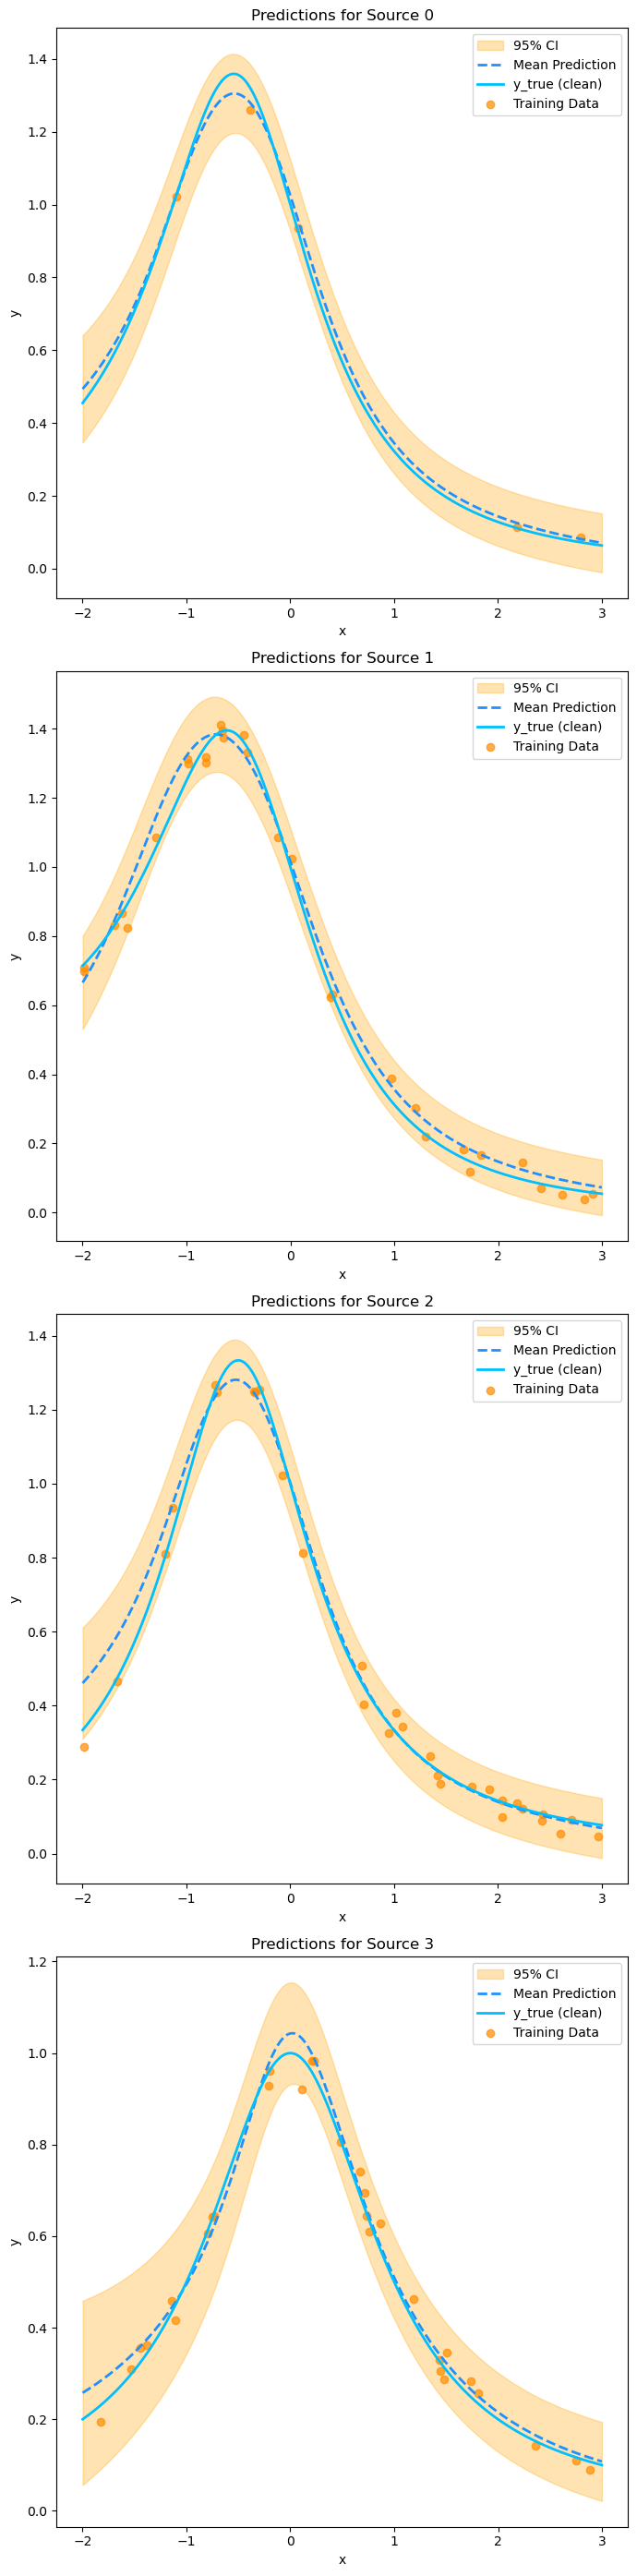

plot_1D completed successfully!


In [14]:
# Test plot_1D function
# Note: For 1D plotting, we need to scale/unscale data if needed
# Since the rational dataset is already in a reasonable range, we'll plot without scaling

print("Testing plot_1D...")

# Set source functions
yh = lambda cat, x: 1.0 / ((0.1 * x[:] ** 3) + (x[:] ** 2) + x[:] + 1)
yl1 = lambda cat, x: 1.0 / ((0.2 * x[:] ** 3) + (x[:] ** 2) + x[:] + 1)
yl2 = lambda cat, x: 1.0 / ((x[:] ** 2) + x[:] + 1)
yl3 = lambda cat, x:  1.0 / ((x[:] ** 2)+ 1)
source_functions = [yh, yl1, yl2, yl3]

fig = plotting.plot_1D(
    model=model,
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset,
    scaler=None,  # or your scaler if data was scaled
    device=device,
    batch_size=32,
    source_functions=source_functions,
    use_source_functions=True  # Enable clean target generation
)
# fig_1d = plotting.plot_1D(
#     model=model,
#     train_dataset=train_dataset,
#     val_dataset=val_dataset,
#     test_dataset=test_dataset,
#     scaler=None,  # No scaling for now
#     device=device,
#     batch_size=32
# )
plt.show()
print("plot_1D completed successfully!")

Testing plot_true_pred...


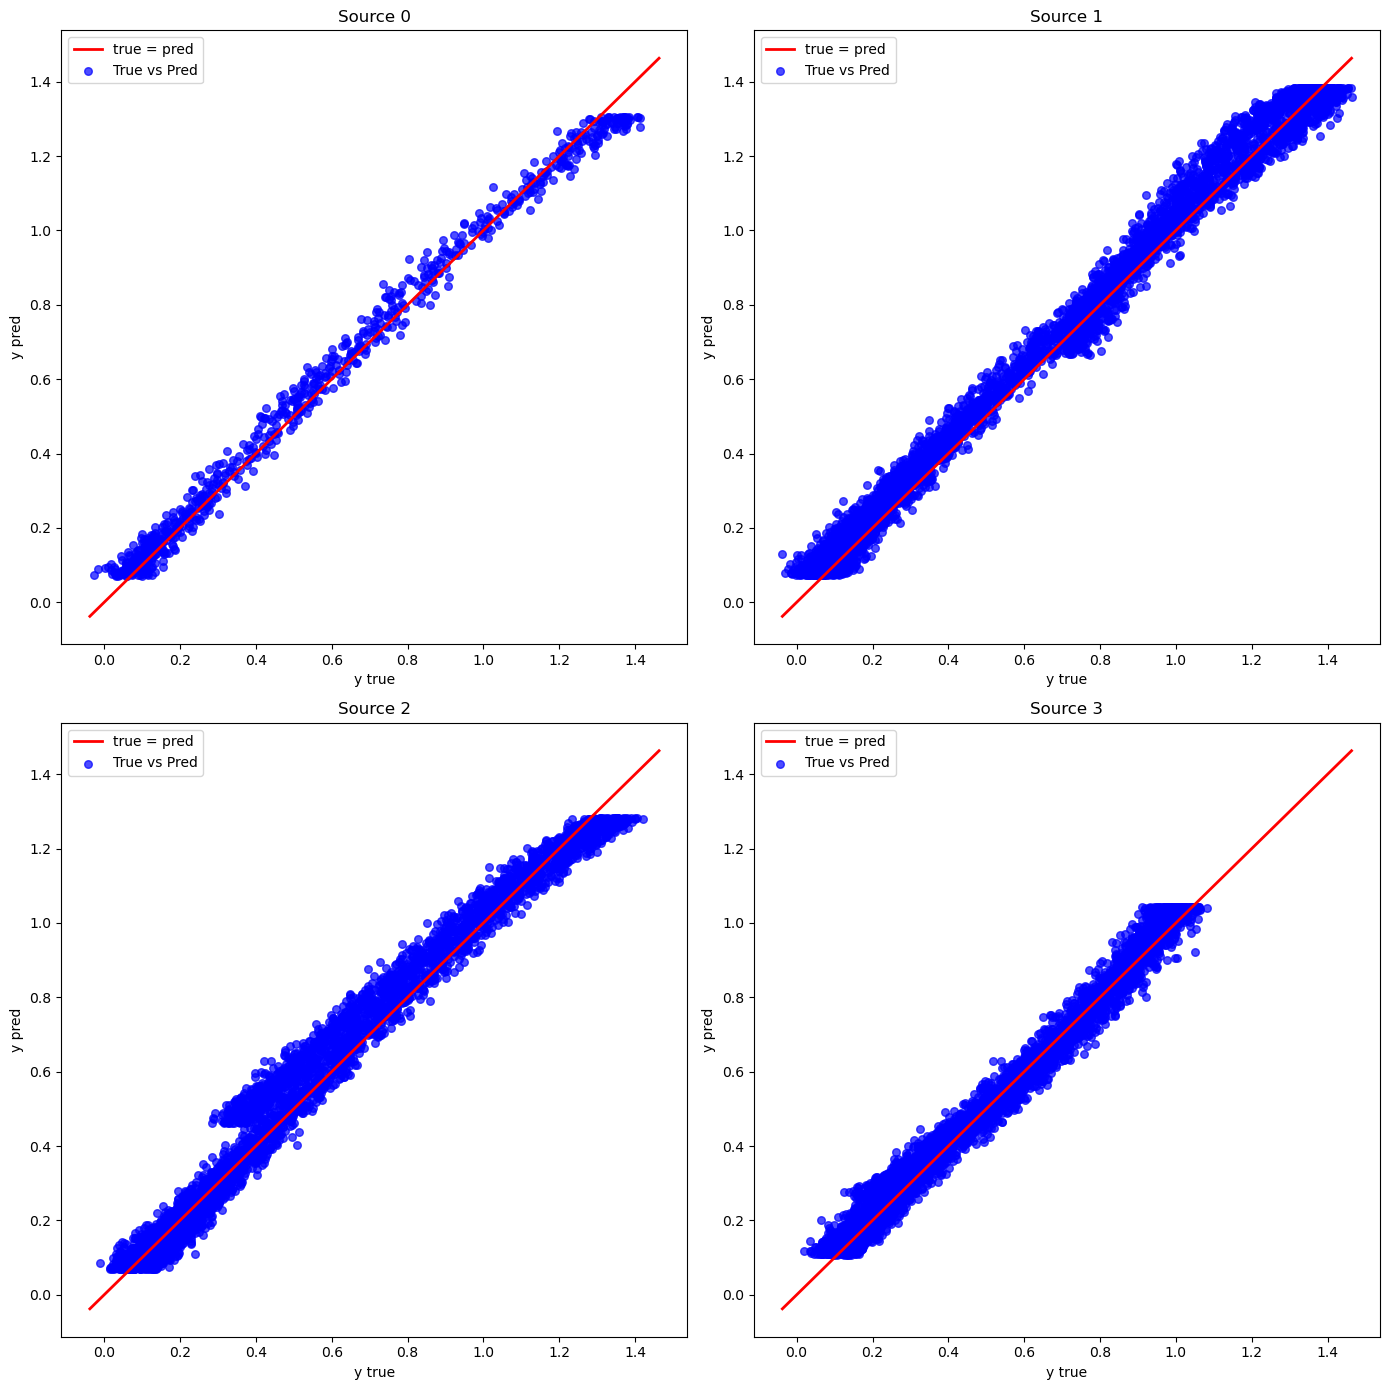

plot_true_pred completed successfully!


In [15]:
# Test plot_true_pred function
print("Testing plot_true_pred...")
fig_true_pred = plotting.plot_true_pred(
    model=model,
    test_dataset=test_dataset,
    device=device,
    batch_size=32,
    colors=("red", "blue"),
    lw=2,
    s=30,
    figsize=7
)
plt.show()
print("plot_true_pred completed successfully!")

Testing plot_2D_latent_space (B1 - source latent space)...


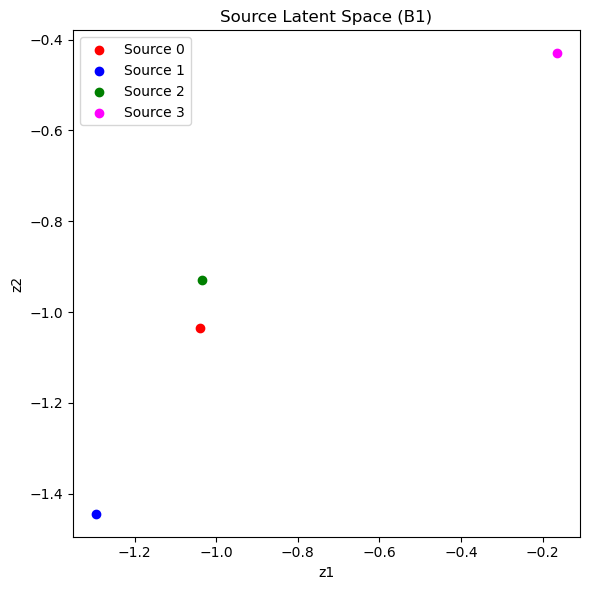

plot_2D_latent_space (B1) completed successfully!


In [16]:
# Test plot_2D_latent_space for source latent space (B1)
print("Testing plot_2D_latent_space (B1 - source latent space)...")
fig_latent_b1 = plotting.plot_2D_latent_space(
    model=model,
    block_idx=0,  # B1 (source block)
    dcat=dcat,  # Not used for B1, but required parameter
    device=device,
    figsize=6,
    num_iterations=100
)
plt.show()
print("plot_2D_latent_space (B1) completed successfully!")

## 5. Evaluate Model Performance

In [17]:
# Evaluate model on test set
from plotting import _get_predictions

model.eval()
test_preds, test_means, test_stds = _get_predictions(model, test_dataset, device, batch_size=32)

# Use mean predictions if probabilistic
if test_means is not None:
    y_pred = test_means
else:
    y_pred = test_preds

y_true = test_dataset.targets

# Calculate metrics
mse = np.mean((y_true - y_pred) ** 2)
rmse = np.sqrt(mse)
mae = np.mean(np.abs(y_true - y_pred))

print("Test Set Performance:")
print(f"  - MSE: {mse:.6f}")
print(f"  - RMSE: {rmse:.6f}")
print(f"  - MAE: {mae:.6f}")

# Calculate per-source metrics
source_OH = test_dataset.source
n_sources = source_OH.shape[1]

print("\nPer-Source Performance:")
for i in range(n_sources):
    source_mask = source_OH[:, i] == 1
    if np.any(source_mask):
        source_mse = np.mean((y_true[source_mask] - y_pred[source_mask]) ** 2)
        source_rmse = np.sqrt(source_mse)
        source_mae = np.mean(np.abs(y_true[source_mask] - y_pred[source_mask]))
        print(f"  - Source {i}:")
        print(f"      MSE: {source_mse:.6f}")
        print(f"      RMSE: {source_rmse:.6f}")
        print(f"      MAE: {source_mae:.6f}")
        print(f"      Samples: {np.sum(source_mask)}")

Test Set Performance:
  - MSE: 0.002529
  - RMSE: 0.050287
  - MAE: 0.039241

Per-Source Performance:
  - Source 0:
      MSE: 0.001646
      RMSE: 0.040570
      MAE: 0.032213
      Samples: 792
  - Source 1:
      MSE: 0.002712
      RMSE: 0.052079
      MAE: 0.042568
      Samples: 4752
  - Source 2:
      MSE: 0.003395
      RMSE: 0.058264
      MAE: 0.043862
      Samples: 4752
  - Source 3:
      MSE: 0.001627
      RMSE: 0.040331
      MAE: 0.032463
      Samples: 4752


## 6. Summary

All tests completed successfully! The notebook has validated:
- ✅ Data loading and dataset functionality
- ✅ Model creation and configuration
- ✅ Model forward pass and output structure
- ✅ Model training on rational dataset
- ✅ Plotting functions (plot_1D, plot_true_pred, plot_2D_latent_space)
- ✅ Model evaluation and performance metrics